# AI-3: Natural Language Processing
## PROJECT: IMAGE CAPTIONING FOR ACADEMIC AND SCIENTIFIC PLOTS AND FIGURES

**AI3 Cohort 2**<br/>
**Univ.AI**<br/>
**Instructor**: Prof. Pavlos Protopapas<br />

<hr style="height:2.4pt">

## Names of the people who worked on this project together
**<font color='red'>Bhaskar Bharat, Ekanki Agarwal, Prerna Mahajan and Viraj Kadam</font>**

# CNN+LSTM Trained on Univ AI Dataset

Since the plots in SCICAP Dataset do not contain very distinguishing features but have captions very different than the others, therefore the performance of our models in the previous two notebooks has suffered because of this inherent problem with the dataset.

Therefore, in this notebook we are trying to train our CNN + LSTM network directly on the Univ_AI_Dataset. This is a dataset that we have curated using lecture slides from courses AI-1, AI-2, DS-1 and DS-2. We generate captions on new images using this model and evaluate the performance using [BLEU-4](https://cloud.google.com/translate/automl/docs/evaluate#bleu) scores and see if the performance improves.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import all the required packages

In [3]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import time
import json
import tqdm

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

## Download and prepare the univ_ai_dataset

In [4]:
!unzip "/content/drive/MyDrive/Colab Notebooks/AI-3/Project/AI-3 Project Dataset bobbig/univ_ai_dataset.zip"

Archive:  /content/drive/MyDrive/Colab Notebooks/AI-3/Project/AI-3 Project Dataset bobbig/univ_ai_dataset.zip
   creating: univ_ai_dataset/captions/
  inflating: univ_ai_dataset/captions/captions.json  
  inflating: univ_ai_dataset/captions/captions.txt  
   creating: univ_ai_dataset/images/
  inflating: univ_ai_dataset/images/ekanki-image-1.png  
  inflating: univ_ai_dataset/images/ekanki-image-10.png  
  inflating: univ_ai_dataset/images/ekanki-image-100.png  
  inflating: univ_ai_dataset/images/ekanki-image-11.png  
  inflating: univ_ai_dataset/images/ekanki-image-12.png  
  inflating: univ_ai_dataset/images/ekanki-image-13.png  
  inflating: univ_ai_dataset/images/ekanki-image-14.png  
  inflating: univ_ai_dataset/images/ekanki-image-15.png  
  inflating: univ_ai_dataset/images/ekanki-image-16.png  
  inflating: univ_ai_dataset/images/ekanki-image-17.png  
  inflating: univ_ai_dataset/images/ekanki-image-18.png  
  inflating: univ_ai_dataset/images/ekanki-image-19.png  
  inflating

## Load the Images and Captions

In [5]:
num_images = 100

In [6]:
with open("/content/univ_ai_dataset/univ_caption.json", 'r') as f:
  train_caption = json.load(f)

In [7]:
train_img_dir = "/content/univ_ai_dataset/images/"

train_captions = []
img_name_vector = []

for img in list(train_caption.keys())[:num_images]:
  caption = train_caption[img]
  img_path = train_img_dir+img
  train_captions.append(caption)
  img_name_vector.append(img_path)

<start> roc curves showing discriminatory power of best classifier compared to perfect and random classifiers <end>


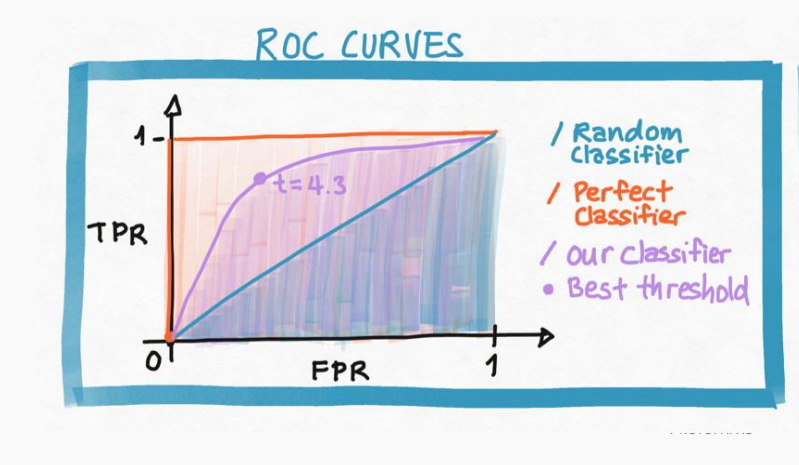

In [8]:
n = 11
print(train_captions[n])
Image.open(img_name_vector[n])

In [9]:
type(Image.open(img_name_vector[n]))

PIL.PngImagePlugin.PngImageFile

## Preprocess the images using InceptionV3
Next, we will use InceptionV3 (which is pretrained on Imagenet) to classify each image. We will extract features from the last convolutional layer.

First, we will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [10]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.keras.layers.Resizing(height=299, width=299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now we'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```2048```. We don't perform this initialization during training because it could become a bottleneck.

* We forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, we save the dictionary to disk.


In [11]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet',
                                                pooling='avg')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
image_features_extract_model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                  

## Caching the features extracted from InceptionV3

We will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 2048 floats per image. This might exceed the memory limitations of Colab (currently 12GB of memory).

In [12]:
# Get unique images
encode_train = img_name_vector

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  # batch_features = tf.reshape(batch_features,
  #                             (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

We will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top 10,000 words (to save memory).
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [13]:
tmp = []
for ele in train_captions:
  tmp.append(len(ele.split()))
max(tmp)

52

In [14]:
np.mean(np.array(tmp))

16.25

In [15]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  # return inputs
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 30
# Use the top 5000 words for a vocabulary.
vocabulary_size = 2000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [16]:
cap_in = [" ".join(ele.split()[:-1]) for ele in train_captions]
cap_out = [" ".join(ele.split()[1:]) for ele in train_captions]

cap_in_dataset = tf.data.Dataset.from_tensor_slices(cap_in)
cap_out_dataset = tf.data.Dataset.from_tensor_slices(cap_out)

# Create the tokenized vectors
cap_in_vector = cap_in_dataset.map(lambda x: tokenizer(x))
cap_out_vector = cap_out_dataset.map(lambda x: tokenizer(x))

In [17]:
for ele in cap_in_vector:
  print(ele)
  break

tf.Tensor(
[  2  62 187 405 439   6 376 328  16 325   6 321   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0], shape=(30,), dtype=int64)


In [18]:
for ele in cap_out_vector:
  print(ele)
  break

tf.Tensor(
[ 62 187 405 439   6 376 328  16 325   6 321   3   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0], shape=(30,), dtype=int64)


In [19]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [20]:
word_to_index("<start>")

<tf.Tensor: shape=(), dtype=int64, numpy=2>

In [21]:
index_to_word(1)

<tf.Tensor: shape=(), dtype=string, numpy=b'[UNK]'>

## Split the data into training and validation

In [22]:
img_to_cap_in_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_in_vector):
  img_to_cap_in_vector[img].append(cap)

img_to_cap_out_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_out_vector):
  img_to_cap_out_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_in_vector.keys())
random.shuffle(img_keys)

slice_index = 95
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_in_train = []
cap_out_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_in_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_in_train.extend(img_to_cap_in_vector[imgt])
  cap_out_train.extend(img_to_cap_out_vector[imgt])

img_name_val = []
cap_in_val = []
cap_out_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_in_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_in_val.extend(img_to_cap_in_vector[imgv])
  cap_out_val.extend(img_to_cap_out_vector[imgv])

In [23]:
img_name_train[:5]

['/content/univ_ai_dataset/images/ekanki-image-3.png',
 '/content/univ_ai_dataset/images/ekanki-image-45.png',
 '/content/univ_ai_dataset/images/ekanki-image-23.png',
 '/content/univ_ai_dataset/images/ekanki-image-88.png',
 '/content/univ_ai_dataset/images/ekanki-image-26.png']

In [24]:
cap_in_train[:2]

[<tf.Tensor: shape=(30,), dtype=int64, numpy=
 array([  2,  44,  14, 161, 312, 152, 359, 161, 173,   8,  83,  65, 408,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0])>, <tf.Tensor: shape=(30,), dtype=int64, numpy=
 array([  2,   5, 106,  76,  20,   5, 220, 131, 182,  50,   5, 141,  15,
         97,  66, 190,  11,  65,  66,   6,   5,  76,  20, 319, 154, 182,
         50,   5, 141,  15])>]

In [25]:
cap_out_train[:2]

[<tf.Tensor: shape=(30,), dtype=int64, numpy=
 array([ 44,  14, 161, 312, 152, 359, 161, 173,   8,  83,  65, 408,   3,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0])>, <tf.Tensor: shape=(30,), dtype=int64, numpy=
 array([  5, 106,  76,  20,   5, 220, 131, 182,  50,   5, 141,  15,  97,
         66, 190,  11,  65,  66,   6,   5,  76,  20, 319, 154, 182,  50,
          5, 141,  15,  97])>]

In [26]:
len(img_name_train), len(cap_in_train), len(cap_out_train), len(img_name_val), len(cap_in_val), len(cap_out_val)

(95, 95, 95, 5, 5, 5)

## Create a tf.data dataset for training and validation

Our images and captions are ready! Next, let's create a `tf.data` dataset to use for training and validation of our model.

In [27]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (2048,)
# These two variables represent that vector shape
features_shape = 2048

In [28]:
# Load the numpy files
def map_func(img_name, cap_in, cap_out):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap_in, cap_out

In [29]:
def transform_func(img_tensor, cap_in, cap_out):
  return (img_tensor, cap_in), cap_out

In [30]:
dataset_train = tf.data.Dataset.from_tensor_slices((img_name_train, cap_in_train, cap_out_train))

# Use map to load the numpy files in parallel
dataset_train = dataset_train.map(lambda item1, item2, item3: tf.numpy_function(
          map_func, [item1, item2, item3], [tf.float32, tf.int64, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

dataset_train = dataset_train.map(transform_func, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
dataset_val = tf.data.Dataset.from_tensor_slices((img_name_val, cap_in_val, cap_out_val))

# Use map to load the numpy files in parallel
dataset_val = dataset_val.map(lambda item1, item2, item3: tf.numpy_function(
          map_func, [item1, item2, item3], [tf.float32, tf.int64, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

dataset_val = dataset_val.map(transform_func, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset_val = dataset_val.batch(BATCH_SIZE)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
# View some data from dataset_train
for (img_tensor, cap_in), cap_out in dataset_train.take(1):
  print(img_tensor.shape,cap_in.shape)
  print(img_tensor[0])
  print(cap_in[0])
  print("************************")
  print(cap_out.shape)
  print(cap_out[0])

(32, 2048) (32, 30)
tf.Tensor([0.01099008 0.24215415 0.04032709 ... 0.5327593  0.09075275 0.0292989 ], shape=(2048,), dtype=float32)
tf.Tensor(
[  2   7   9  51  24 172   8  17   6  31  10  12  58  24 194  23  27  13
   8 332 148  79   0   0   0   0   0   0   0   0], shape=(30,), dtype=int64)
************************
(32, 30)
tf.Tensor(
[  7   9  51  24 172   8  17   6  31  10  12  58  24 194  23  27  13   8
 332 148  79   3   0   0   0   0   0   0   0   0], shape=(30,), dtype=int64)


In [33]:
# View some data from dataset_val
for (img_tensor, cap_in), cap_out in dataset_val.take(1):
  print(img_tensor.shape,cap_in.shape)
  print(img_tensor[0])
  print(cap_in[0])
  print("************************")
  print(cap_out.shape)
  print(cap_out[0])

(5, 2048) (5, 30)
tf.Tensor([0.12854931 0.09597623 0.03643632 ... 0.00797878 0.         0.08458531], shape=(2048,), dtype=float32)
tf.Tensor(
[  2   7   9   5  64   4  43 264   8  14 203   8 346 119 134   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0], shape=(30,), dtype=int64)
************************
(5, 30)
tf.Tensor(
[  7   9   5  64   4  43 264   8  14 203   8 346 119 134   3   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0], shape=(30,), dtype=int64)


## Define the CNN-LSTM model
From the Functional API, we will use the Keras Model in order to define the structure of the model. It includes:

Feature Extractor –With a dense layer, it will extract the feature from the images of size 2048 and we will decrease the dimensions to 256 nodes.

Sequence Processor – Followed by the LSTM layer, the textual input is handled by this embedded layer.

Decoder – We will merge the output of the above two layers and process the dense layer to make the final prediction.

In [34]:
# define the captioning model
def define_model(units, embedding_dim, vocabulary_size, max_length):
  # features from the CNN model compressed from 2048 to 256 nodes
  inputs1 = tf.keras.layers.Input(shape=(features_shape,))
  fe1 = tf.keras.layers.Dropout(0.5)(inputs1)
  fe2 = tf.keras.layers.Dense(embedding_dim, activation='relu')(fe1)
  # fe3 = tf.keras.layers.Reshape((1, embedding_dim))(fe2)
  # LSTM sequence model
  inputs2 = tf.keras.layers.Input(shape=(max_length,))
  se1 = tf.keras.layers.Embedding(vocabulary_size, embedding_dim, mask_zero=True)(inputs2)
  add1 = tf.keras.layers.add([fe2, se1])
  se2 = tf.keras.layers.LSTM(embedding_dim, return_sequences=True)(add1)
  add2 = tf.keras.layers.add([fe2, se2])
  se3 = tf.keras.layers.LSTM(embedding_dim, return_sequences=True)(add2)
  # Merging both models
  decoder1 = tf.keras.layers.add([fe2, se3])
  decoder2 = tf.keras.layers.Dense(units, activation='relu')(decoder1)
  outputs = tf.keras.layers.Dense(vocabulary_size, activation='softmax')(decoder2)
  # merge it [image, seq] [word]
  model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)
  # summarize model
  print(model.summary())
  return model

In [35]:
model = define_model(units, embedding_dim, vocabulary_size, max_length)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['dropout[0][0]']                
                                                                                            

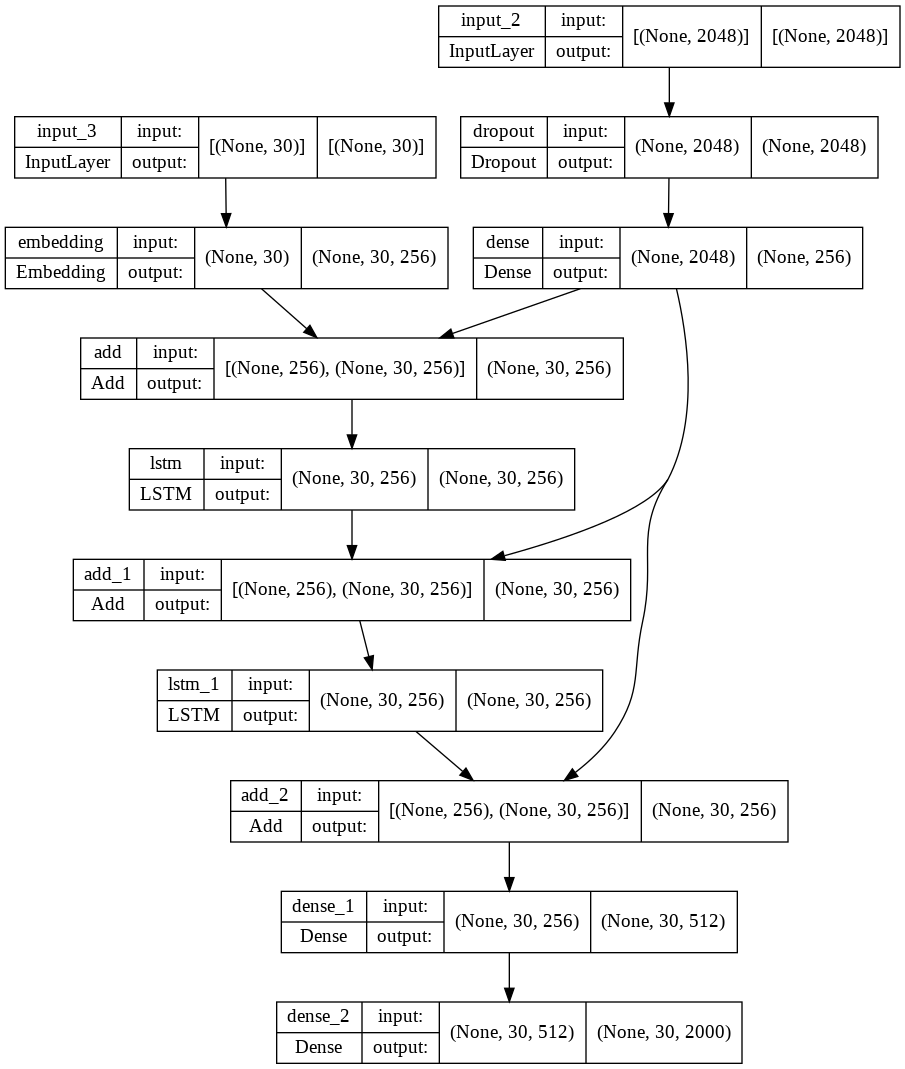

In [36]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

## Training

In [37]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [38]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer_func = tf.keras.optimizers.RMSprop()

epochs = 80

for epoch in range(epochs):
  total_loss = 0
  for (img_tensor, cap_in), cap_out in dataset_train:
    loss = 0
    with tf.GradientTape() as tape:
      predictions = model([img_tensor, cap_in])
      loss = loss_func(cap_out, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer_func.apply_gradients(zip(gradients, model.trainable_variables))
    total_loss += loss
  loss_plot.append(total_loss/num_steps)
  print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')

Epoch 1 Loss 9.215231
Epoch 2 Loss 6.007024
Epoch 3 Loss 4.192182
Epoch 4 Loss 4.032476
Epoch 5 Loss 3.961781
Epoch 6 Loss 3.920857
Epoch 7 Loss 3.858707
Epoch 8 Loss 3.835196
Epoch 9 Loss 3.804579
Epoch 10 Loss 3.794419
Epoch 11 Loss 3.689069
Epoch 12 Loss 3.663669
Epoch 13 Loss 3.547208
Epoch 14 Loss 3.524019
Epoch 15 Loss 3.486438
Epoch 16 Loss 3.675907
Epoch 17 Loss 3.317353
Epoch 18 Loss 3.395598
Epoch 19 Loss 3.187327
Epoch 20 Loss 3.142282
Epoch 21 Loss 3.077885
Epoch 22 Loss 3.044823
Epoch 23 Loss 3.019358
Epoch 24 Loss 2.857576
Epoch 25 Loss 2.835583
Epoch 26 Loss 2.798559
Epoch 27 Loss 2.649757
Epoch 28 Loss 2.728484
Epoch 29 Loss 2.604466
Epoch 30 Loss 2.506990
Epoch 31 Loss 2.378395
Epoch 32 Loss 2.567115
Epoch 33 Loss 2.423620
Epoch 34 Loss 2.353801
Epoch 35 Loss 2.250208
Epoch 36 Loss 2.206722
Epoch 37 Loss 2.295669
Epoch 38 Loss 2.200982
Epoch 39 Loss 2.114471
Epoch 40 Loss 2.165652
Epoch 41 Loss 2.032709
Epoch 42 Loss 2.084206
Epoch 43 Loss 2.094832
Epoch 44 Loss 2.0333

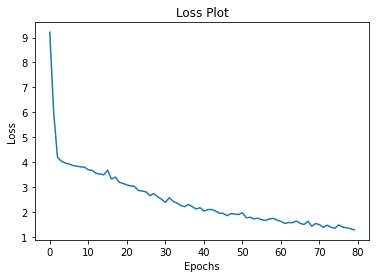

In [39]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.

In [40]:
def evaluate(image):

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions = model([img_tensor_val, dec_input])

        predicted_id = tf.random.categorical(tf.squeeze(predictions, axis=0), 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

Real Caption: <start> plot showing the comparison of error rates for different years for imagenet visual recognition
Prediction Caption: confidence [UNK] [UNK] kannada [UNK] [UNK] coefficients [UNK] [UNK] [UNK] relationship well [UNK] [UNK] [UNK] [UNK] probability it [UNK] [UNK] [UNK] [UNK] too convex [UNK] [UNK] longitude [UNK] [UNK] [UNK]


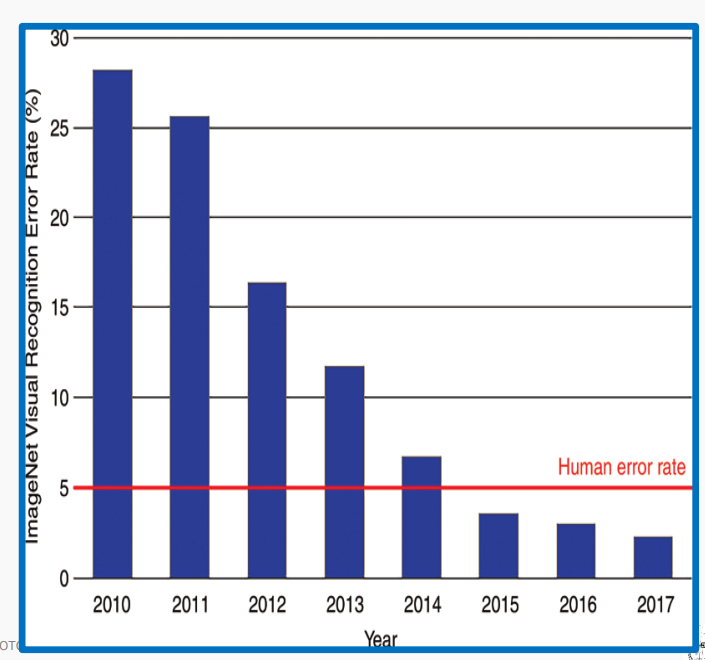

In [41]:
# captions on the validation set
rid = 0
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_in_val[rid] if i not in [0]])
result = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
Image.open(image)

In [42]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0


In [43]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0
Individual 2-gram: 0
Individual 3-gram: 0
Individual 4-gram: 0


Real Caption: <start> loss plot for random forest on train and validation data as number of trees increase
Prediction Caption: [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] regularized intervals [UNK] [UNK] [UNK] [UNK] boundary [UNK] [UNK] [UNK] [UNK] [UNK] exists market [UNK] [UNK] [UNK] test [UNK] components axis


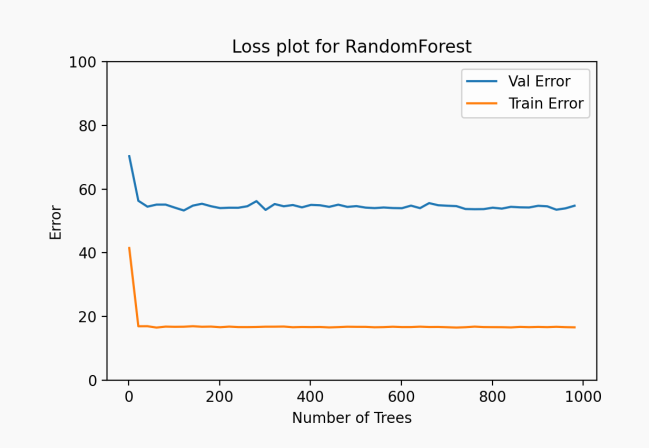

In [44]:
# captions on the validation set
rid = 1
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_in_val[rid] if i not in [0]])
result = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
Image.open(image)

In [45]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0


In [46]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0
Individual 2-gram: 0
Individual 3-gram: 0
Individual 4-gram: 0


Real Caption: <start> box plot depicting relationship between data variables
Prediction Caption: [UNK] sigmoid [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] club [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] degree density price income [UNK] [UNK]


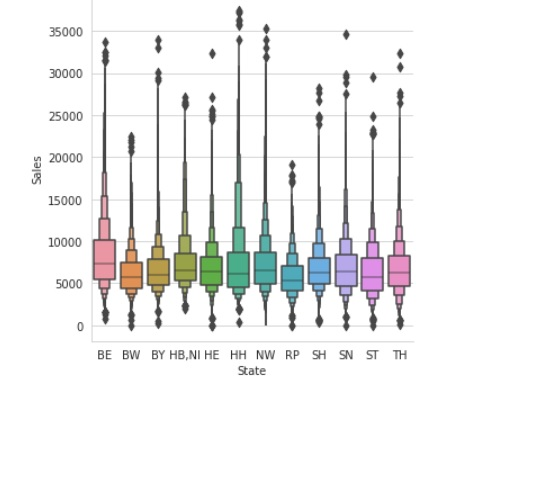

In [47]:
# captions on the validation set
rid = 2
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_in_val[rid] if i not in [0]])
result = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
Image.open(image)

In [48]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0


In [49]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0
Individual 2-gram: 0
Individual 3-gram: 0
Individual 4-gram: 0


Real Caption: <start> plot showing top 10 predictors by relative importance as identfied using permutation importance
Prediction Caption: [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] visual [UNK] [UNK] [UNK] [UNK] blobs real regions [UNK] [UNK] [UNK] test [UNK] [UNK] [UNK] where [UNK] regressors [UNK]


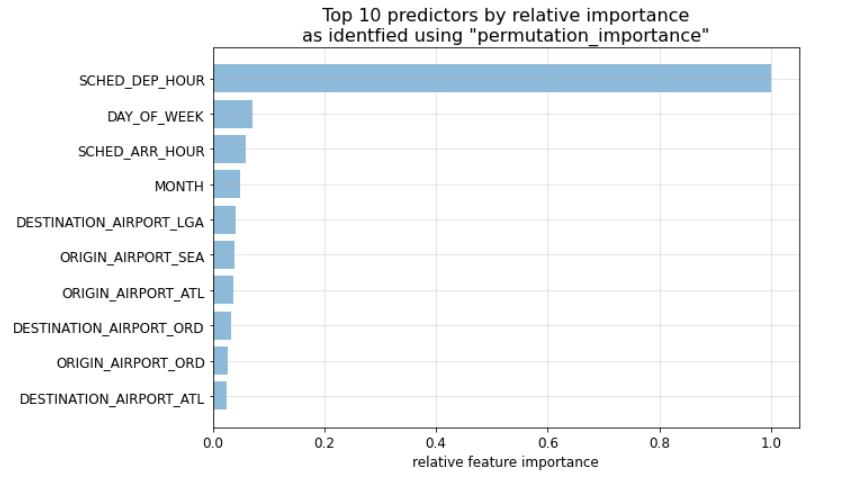

In [50]:
# captions on the validation set
rid = 3
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_in_val[rid] if i not in [0]])
result = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
Image.open(image)

In [51]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0


In [52]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0
Individual 2-gram: 0
Individual 3-gram: 0
Individual 4-gram: 0


Real Caption: <start> quadratic relation that is polynomial fit of degree 2 being shown between x and y
Prediction Caption: [UNK] [UNK] kannada [UNK] comparing [UNK] [UNK] [UNK] mnist [UNK] predicted [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]


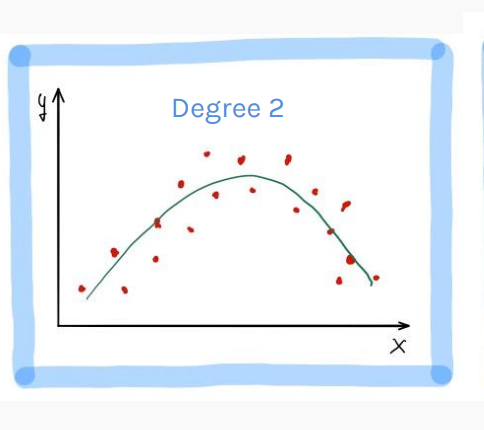

In [53]:
# captions on the validation set
rid = 4
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_in_val[rid] if i not in [0]])
result = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
Image.open(image)

In [54]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0


In [55]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0
Individual 2-gram: 0
Individual 3-gram: 0
Individual 4-gram: 0


In [ ]:
# # Saving fine-tuned model weights
# model.save_weights("/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/cnn_lstm/model_weights.ckpt")

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


Prediction Caption: exhibits best [UNK] [UNK] per [UNK] [UNK] [UNK] [UNK] sigmoid [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] interaction [UNK] attributed [UNK] [UNK] [UNK] tsne [UNK] [UNK] [UNK] shaped [UNK] batch [UNK]


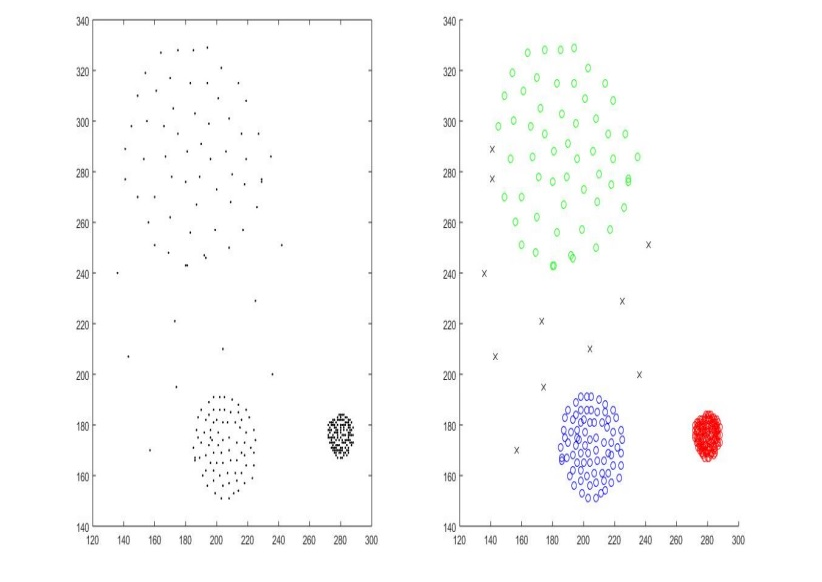

In [56]:
test_dir = "/content/univ_ai_dataset/images/"
img_name = "prerna-image-10.png"

image_path = test_dir + img_name

result = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))

# opening the image
Image.open(image_path)